In [ ]:
#unzip our data
!unzip -q "/content/drive/MyDrive/intern dl/pran/archive (4).zip"

replace annotations/Cars0.xml? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

In [ ]:
#import packages
import matplotlib.pyplot as plt
from bs4 import BeautifulSoup
import numpy as np 
import pandas as pd
import os
from time import perf_counter
import cv2
import tensorflow as tf

In [ ]:
dataFrame = {
    'image' : [],
    'box'   : [],
}

In [ ]:
# A composite function for loading and drawing box
# around license plate 
def Reader(path, annotPath, size = 256, isPlot = False, showTime = False):
    
    start = perf_counter()
    img = plt.imread(path)
    img =  np.array (img[:, :, 0:3])
    
    if isPlot:
        plt.subplot(1, 2, 1)
        plt.imshow(img)
   
    # parsing html
    with open(annotPath, 'r') as f: 
        data = f.read() 
    
    Bs = BeautifulSoup(data, "xml")
    xMax = int (Bs.find('xmax').text)
    xMin = int (Bs.find('xmin').text)
    yMax = int (Bs.find('ymax').text)
    yMin = int (Bs.find('ymin').text)
    #print(xMin, xMax, yMin, yMax, img.shape)
    # storing data
    dataFrame['image'].append  ( cv2.resize(img, (size, size)))
    # drawing box
    #imgBoxed = cv2.rectangle(img, (xMin, yMin), (xMax, yMax), (0 ,255, 0), 2)
    # storing data into frame
    x = yMin
    while x < yMax:
        y = xMin
        while y < xMax:
            img[x, y, 1] = 1
            y += 1
        x += 1
        
    dataFrame['box'].append (cv2.resize(img, (size, size)))
    
    if isPlot:
        plt.subplot(1, 2, 2)
        plt.imshow(cv2.resize(imgBoxed, (size,size)))
    
    if showTime:
        return perf_counter() - start
    
    
    

In [ ]:
# defining Iterator
def Iterator(imageDir, annotDir):
    start = perf_counter()
    imageNames = os.listdir(imageDir)
    
    for mem in imageNames:
        path = imageDir + '/' + mem
        annotPath = annotDir + '/' + mem.split('.')[0] + '.xml'
        Reader(path, annotPath)
       
    return perf_counter() - start

In [ ]:
Iterator('/content/images' ,'/content/annotations')

11.678858949999949

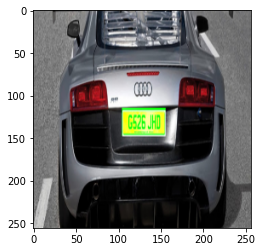

In [ ]:
plt.imshow(dataFrame['box'][3])

In [ ]:
# defining autoencoder model
def Conv2dBlock(inputTensor, numFilters, kernelSize = 3, doBatchNorm = True):
    #first Conv
    x = tf.keras.layers.Conv2D(filters = numFilters, kernel_size = (kernelSize, kernelSize),
                              kernel_initializer = 'he_normal', padding = 'same') (inputTensor)
    
    if doBatchNorm:
        x = tf.keras.layers.BatchNormalization()(x)
        
    x =tf.keras.layers.Activation('relu')(x)
    
    #Second Conv
    x = tf.keras.layers.Conv2D(filters = numFilters, kernel_size = (kernelSize, kernelSize),
                              kernel_initializer = 'he_normal', padding = 'same') (x)
    if doBatchNorm:
        x = tf.keras.layers.BatchNormalization()(x)
        
    x = tf.keras.layers.Activation('relu')(x)
    
    return x


# Now defining Unet 
def GiveMeUnet(inputImage, numFilters = 16, droupouts = 0.1, doBatchNorm = True):
    # defining encoder Path
    c1 = Conv2dBlock(inputImage, numFilters * 1, kernelSize = 3, doBatchNorm = doBatchNorm)
    p1 = tf.keras.layers.MaxPooling2D((2,2))(c1)
    p1 = tf.keras.layers.Dropout(droupouts)(p1)
    
    c2 = Conv2dBlock(p1, numFilters * 2, kernelSize = 3, doBatchNorm = doBatchNorm)
    p2 = tf.keras.layers.MaxPooling2D((2,2))(c2)
    p2 = tf.keras.layers.Dropout(droupouts)(p2)
    
    c3 = Conv2dBlock(p2, numFilters * 4, kernelSize = 3, doBatchNorm = doBatchNorm)
    p3 = tf.keras.layers.MaxPooling2D((2,2))(c3)
    p3 = tf.keras.layers.Dropout(droupouts)(p3)
    
    c4 = Conv2dBlock(p3, numFilters * 8, kernelSize = 3, doBatchNorm = doBatchNorm)
    p4 = tf.keras.layers.MaxPooling2D((2,2))(c4)
    p4 = tf.keras.layers.Dropout(droupouts)(p4)
    
    c5 = Conv2dBlock(p4, numFilters * 16, kernelSize = 3, doBatchNorm = doBatchNorm)
    
    # defining decoder path
    u6 = tf.keras.layers.Conv2DTranspose(numFilters*8, (3, 3), strides = (2, 2), padding = 'same')(c5)
    u6 = tf.keras.layers.concatenate([u6, c4])
    u6 = tf.keras.layers.Dropout(droupouts)(u6)
    c6 = Conv2dBlock(u6, numFilters * 8, kernelSize = 3, doBatchNorm = doBatchNorm)
    
    u7 = tf.keras.layers.Conv2DTranspose(numFilters*4, (3, 3), strides = (2, 2), padding = 'same')(c6)
    
    u7 = tf.keras.layers.concatenate([u7, c3])
    u7 = tf.keras.layers.Dropout(droupouts)(u7)
    c7 = Conv2dBlock(u7, numFilters * 4, kernelSize = 3, doBatchNorm = doBatchNorm)
    
    u8 = tf.keras.layers.Conv2DTranspose(numFilters*2, (3, 3), strides = (2, 2), padding = 'same')(c7)
    u8 = tf.keras.layers.concatenate([u8, c2])
    u8 = tf.keras.layers.Dropout(droupouts)(u8)
    c8 = Conv2dBlock(u8, numFilters * 2, kernelSize = 3, doBatchNorm = doBatchNorm)
    
    u9 = tf.keras.layers.Conv2DTranspose(numFilters*1, (3, 3), strides = (2, 2), padding = 'same')(c8)
    u9 = tf.keras.layers.concatenate([u9, c1])
    u9 = tf.keras.layers.Dropout(droupouts)(u9)
    c9 = Conv2dBlock(u9, numFilters * 1, kernelSize = 3, doBatchNorm = doBatchNorm)
    
    output = tf.keras.layers.Conv2D(3, (1, 1), activation = 'sigmoid')(c9)
    model = tf.keras.Model(inputs = [inputImage], outputs = [output])
    return model

In [ ]:
## instanctiating model
inputs = tf.keras.layers.Input((256, 256, 3))
myTransformer = GiveMeUnet(inputs, droupouts= 0.07)
myTransformer.compile(optimizer = 'Adam', loss = 'binary_crossentropy', metrics = ['accuracy'] )

In [ ]:
retVal = myTransformer.fit(np.array(dataFrame['image']), np.array(dataFrame['box']), epochs = 50, verbose = 1)

Epoch 1/50
14/14 [==============================] - 10s 726ms/step - loss: 0.4969 - accuracy: 0.6196
Epoch 2/50
14/14 [==============================] - 10s 720ms/step - loss: 0.4964 - accuracy: 0.6283
Epoch 3/50
14/14 [==============================] - 10s 725ms/step - loss: 0.4967 - accuracy: 0.6363
Epoch 4/50
14/14 [==============================] - 10s 721ms/step - loss: 0.4961 - accuracy: 0.6557
Epoch 5/50
14/14 [==============================] - 10s 725ms/step - loss: 0.4960 - accuracy: 0.6617
Epoch 6/50
14/14 [==============================] - 10s 720ms/step - loss: 0.4952 - accuracy: 0.6617
Epoch 7/50
14/14 [==============================] - 10s 724ms/step - loss: 0.4952 - accuracy: 0.6679
Epoch 8/50
14/14 [==============================] - 10s 725ms/step - loss: 0.4940 - accuracy: 0.6811
Epoch 9/50
14/14 [==============================] - 10s 722ms/step - loss: 0.4935 - accuracy: 0.6886
Epoch 10/50
14/14 [==============================] - 10s 725ms/step - loss: 0.4935 - accura

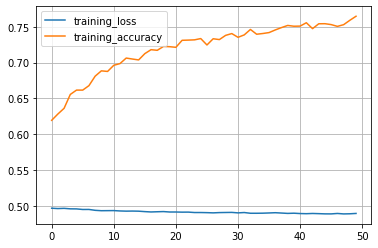

In [ ]:
plt.plot(retVal.history['loss'], label = 'training_loss')
plt.plot(retVal.history['accuracy'], label = 'training_accuracy')
plt.legend()
plt.grid(True)

In [23]:
## function for getting 16 predictions
def predict16 (valMap, model, shape = 256):
    ## getting and proccessing val data
    img = valMap['image']
    mask = valMap['box']
    mask = mask[0:16]
    
    imgProc = img [0:16]
    imgProc = np.array(img)
    
    predictions = model.predict(imgProc)
    for i in range(len(predictions)):
        predictions[i] = cv2.merge((predictions[i,:,:,0],predictions[i,:,:,1],predictions[i,:,:,2]))
    
    return predictions, imgProc, mask

In [24]:
def Plotter(img, predMask, groundTruth):
    plt.figure(figsize=(20,10))
    
    plt.subplot(1,3,1)
    plt.imshow(img)
    plt.title('original Image')
    
    ## Adding Image sharpening step here
    ## it is a sharpening filter
    filter = np.array([[-1, -1, -1], [-1, 8.99, -1], [-1, -1, -1]]) 
    imgSharpen = cv2.filter2D(predMask,-1,filter)
    
    plt.subplot(1,3,2)
    plt.imshow(imgSharpen)
    plt.title('Predicted Box position')
    
    plt.subplot(1,3,3)
    plt.imshow(groundTruth)
    plt.title('actual box Position')

In [25]:
sixteenPrediction, actuals, masks = predict16(dataFrame, myTransformer)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


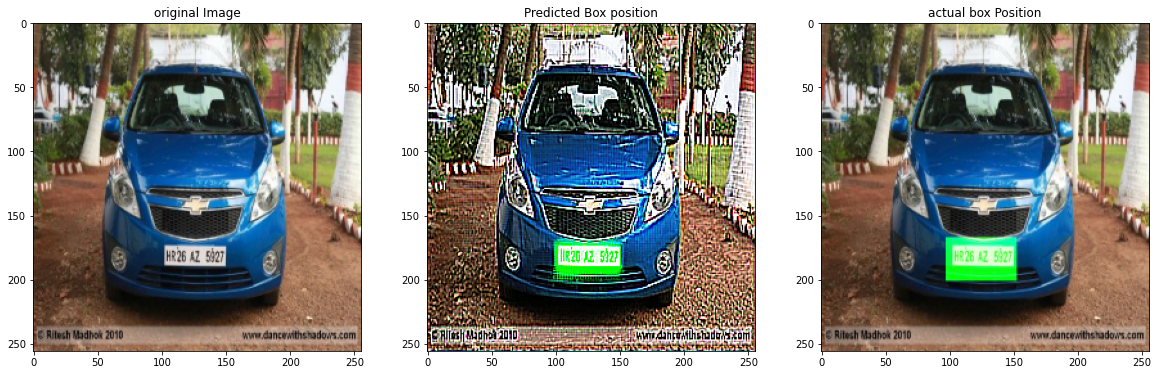

In [26]:
Plotter(actuals[1], sixteenPrediction[1], masks[1])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


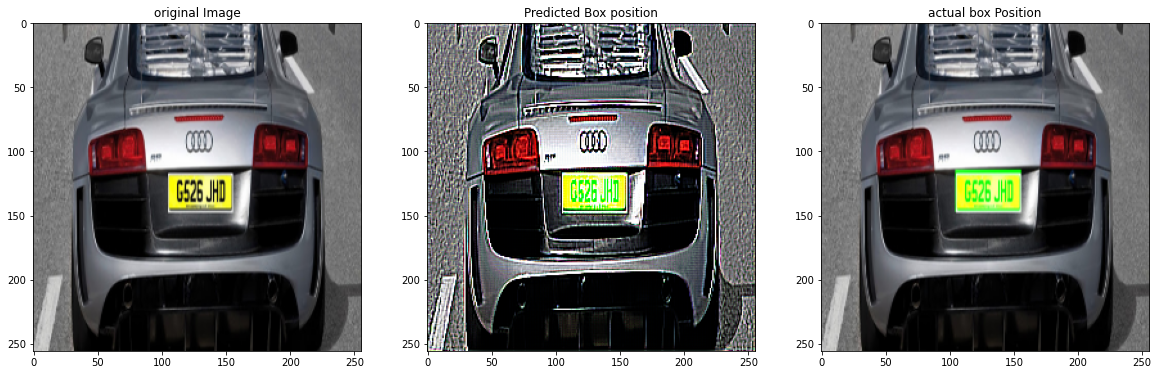

In [28]:
Plotter(actuals[3], sixteenPrediction[3], masks[3])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


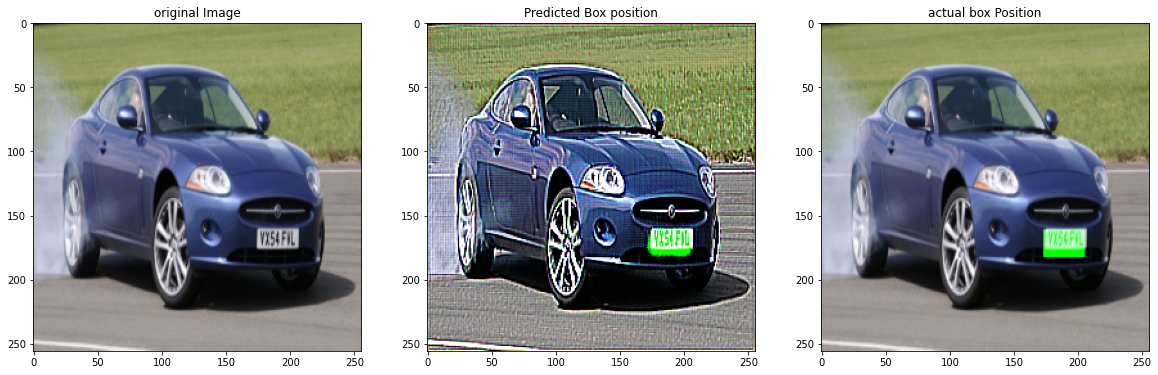

In [29]:
Plotter(actuals[2], sixteenPrediction[2], masks[2])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


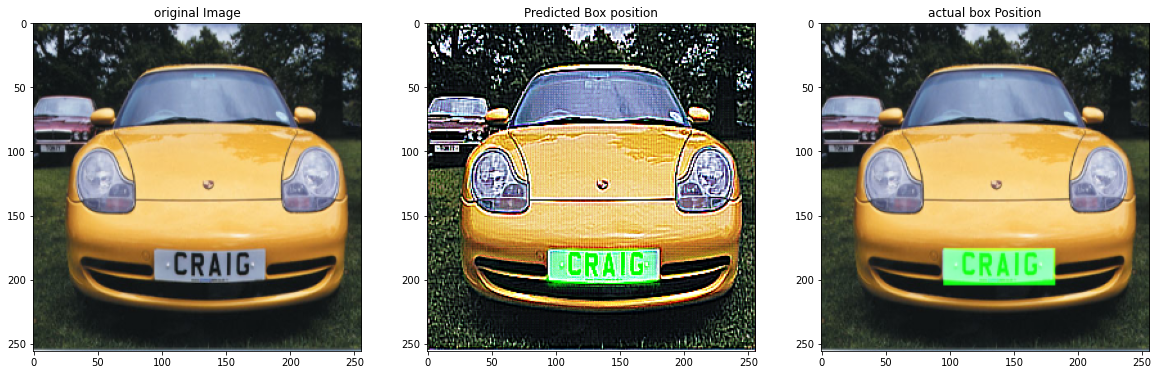

In [30]:
Plotter(actuals[4], sixteenPrediction[4], masks[4])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


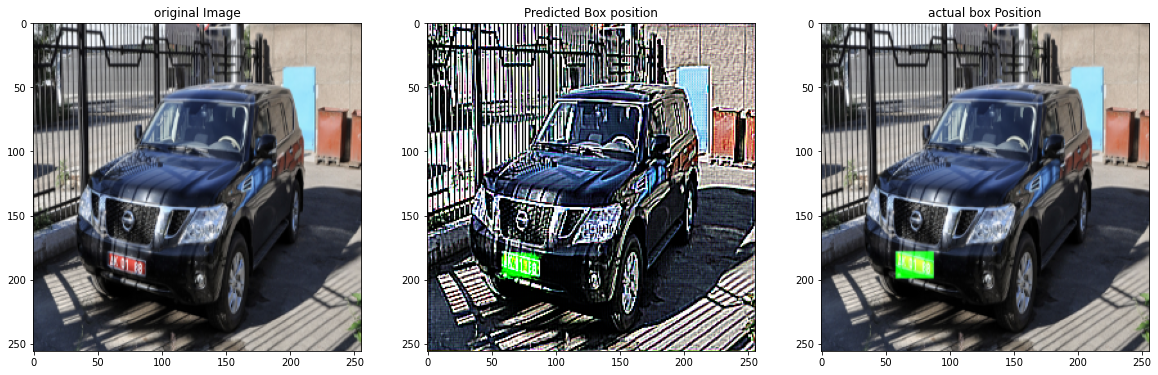

In [31]:
Plotter(actuals[5], sixteenPrediction[5], masks[5])


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


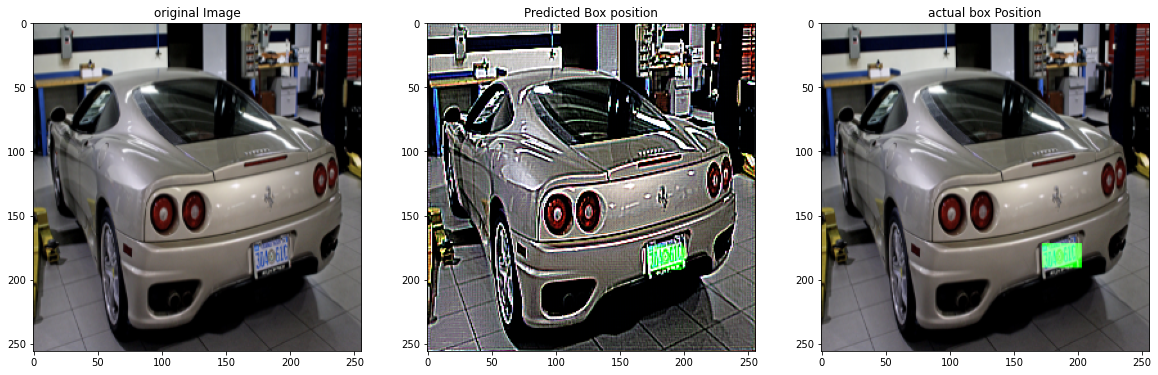

In [32]:
Plotter(actuals[7], sixteenPrediction[7], masks[7])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


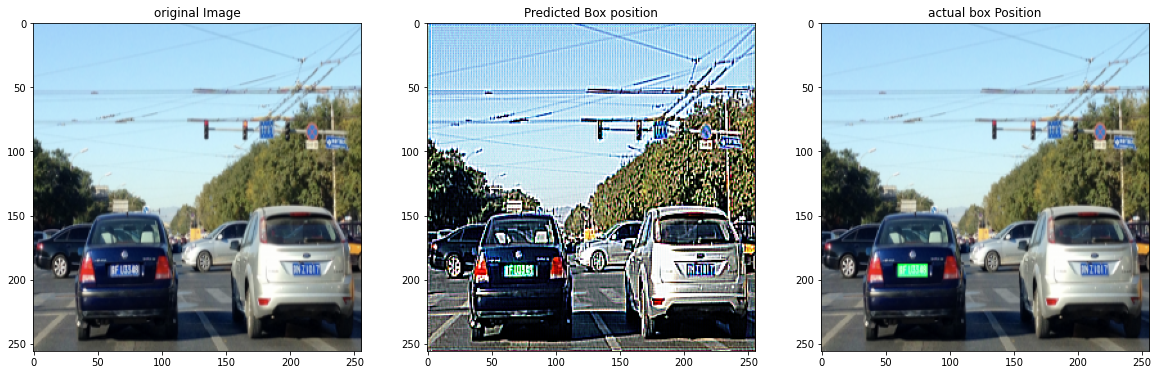

In [33]:
Plotter(actuals[8], sixteenPrediction[8], masks[8])


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


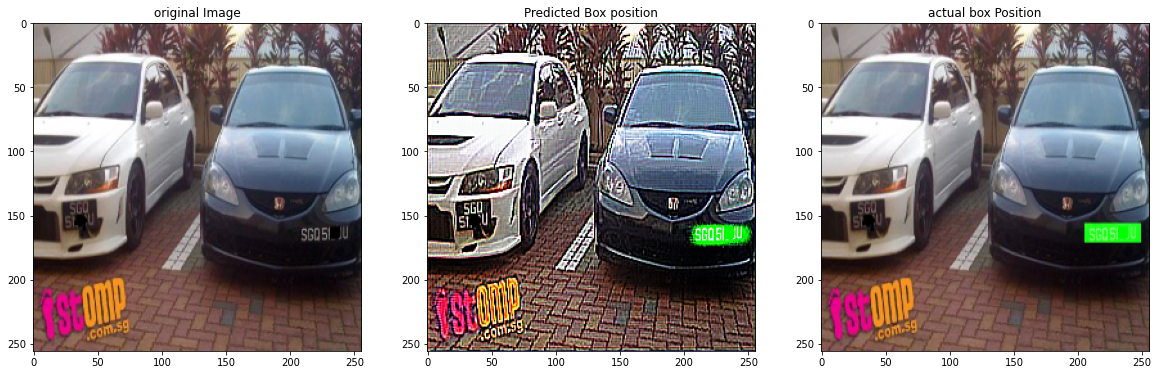

In [34]:
Plotter(actuals[9], sixteenPrediction[9], masks[9])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


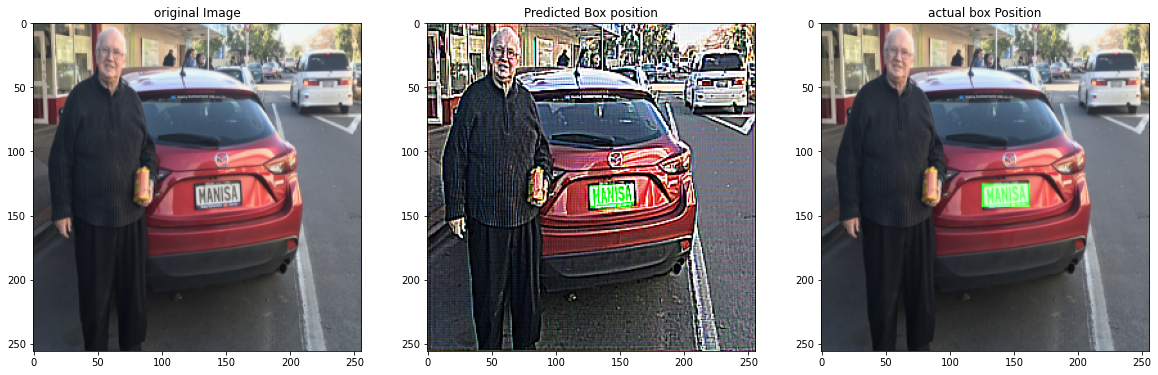

In [35]:
Plotter(actuals[11], sixteenPrediction[11], masks[11])

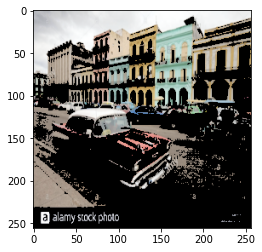

In [36]:
test = sixteenPrediction[12][:,:,1]
test [test >= 0.5] = 1
test[test != 1] = 0
test = cv2.merge((test,test,test))
plt.imshow(test*actuals[12], cmap = 'gray')

In [37]:
#saving model
myTransformer.save('BetterDetector.h5')

applying easyocr on any one randonm image to recognize the text.**bold text**

In [40]:
import numpy as np
import imutils
import easyocr

In [39]:
!pip install easyocr

     |████████████████████████████████| 63.6 MB 75 kB/s 
     |████████████████████████████████| 47.8 MB 77 kB/s 


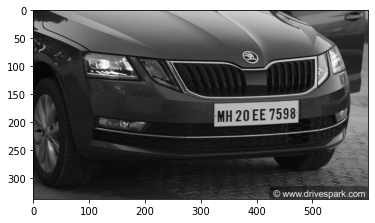

In [43]:
img = cv2.imread('/content/images/Cars111.png')
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
plt.imshow(cv2.cvtColor(gray, cv2.COLOR_BGR2RGB))

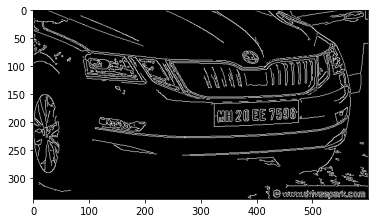

In [44]:
bfilter = cv2.bilateralFilter(gray, 11, 17, 17) #Noise reduction
edged = cv2.Canny(bfilter, 30, 100) #Edge detection
plt.imshow(cv2.cvtColor(edged, cv2.COLOR_BGR2RGB))

In [45]:
keypoints = cv2.findContours(edged.copy(), cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
contours = imutils.grab_contours(keypoints)
contours = sorted(contours, key=cv2.contourArea, reverse=True)[:10]

In [46]:
location = None
for contour in contours:
    approx = cv2.approxPolyDP(contour, 10, True)
    if len(approx) == 4:
        location = approx
        break

In [47]:
location

array([[[475, 161]],

       [[321, 166]],

       [[324, 208]],

       [[475, 201]]], dtype=int32)

In [48]:
mask = np.zeros(gray.shape, np.uint8)
new_image = cv2.drawContours(mask, [location], 0,255, -1)
new_image = cv2.bitwise_and(img, img, mask=mask)

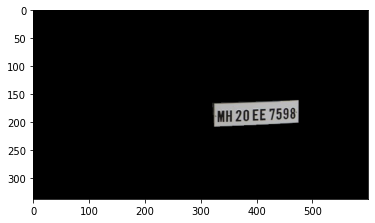

In [49]:
plt.imshow(cv2.cvtColor(new_image, cv2.COLOR_BGR2RGB))

In [50]:
(x,y) = np.where(mask==255)
(x1, y1) = (np.min(x), np.min(y))
(x2, y2) = (np.max(x), np.max(y))
cropped_image = gray[x1:x2+1, y1:y2+1]

In [53]:
reader = easyocr.Reader(['en'])

result = reader.readtext(cropped_image)
result

[([[5, 9], [155, 9], [155, 47], [5, 47]], 'MH 20EE 7598', 0.8355653744747114)]

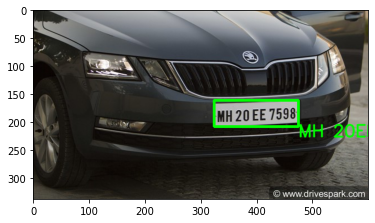

In [54]:
text = str.upper(result[0][1])
font = cv2.FONT_HERSHEY_SIMPLEX
res = cv2.putText(img, text=text, org=(approx[0][0][0], approx[1][0][1]+60), fontFace=font, fontScale=1, color=(0,255,0), thickness=2, lineType=cv2.LINE_AA)
res = cv2.rectangle(img, tuple(approx[0][0]), tuple(approx[2][0]), (0,255,0),3)
plt.imshow(cv2.cvtColor(res, cv2.COLOR_BGR2RGB))